In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("Debernardi_data_augmented_2000_rows.csv")
print(df.shape)
df.head()


(2000, 14)


,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


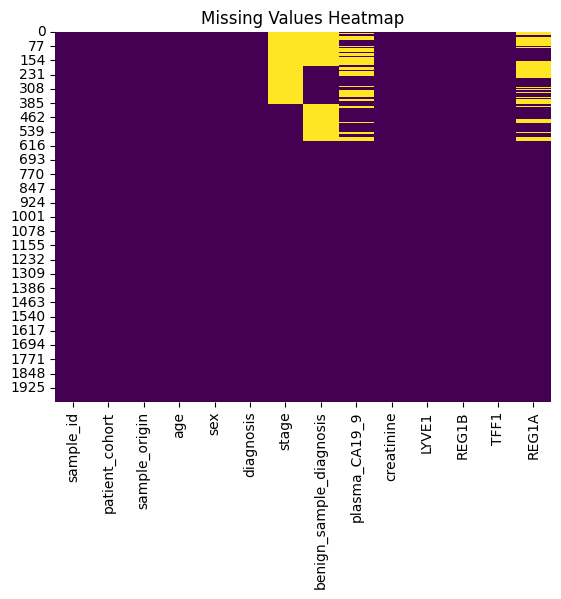

               age    diagnosis  plasma_CA19_9   creatinine        LYVE1  \
count  2000.000000  2000.000000    1760.000000  2000.000000  2000.000000   
mean     59.087000     2.008000     650.881733     0.854767     3.058281   
std       7.140933     0.437072    1088.280942     0.347868     1.872618   
min      26.000000     1.000000       0.000000     0.056550     0.000129   
25%      58.000000     2.000000     500.199510     0.817224     2.830709   
50%      59.000000     2.000000     626.235051     0.851979     3.033911   
75%      60.000000     2.000000     721.087685     0.881502     3.213406   
max      89.000000     3.000000   31000.000000     4.116840    23.890323   

             REG1B          TFF1         REG1A  
count  2000.000000   2000.000000   1716.000000  
mean    111.857023    598.021637    733.924672  
std     106.885176    550.031736    626.367370  
min       0.001104      0.005293      0.000000  
25%      95.987794    525.860267    656.199210  
50%     109.346872   

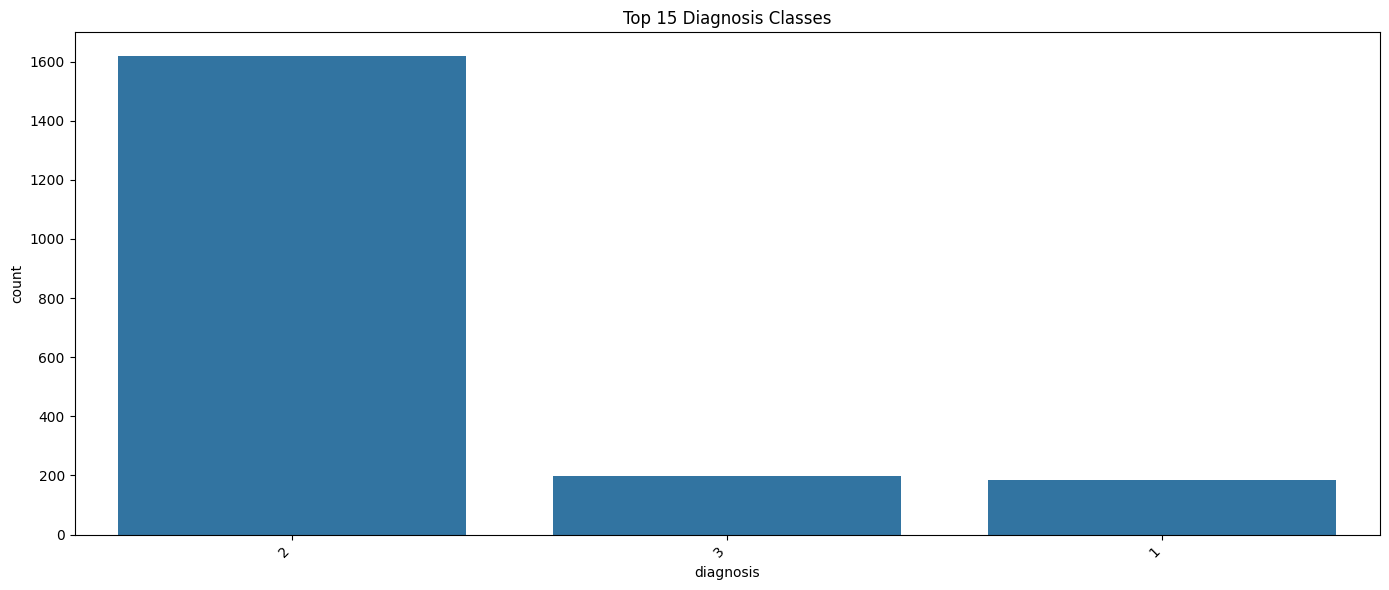

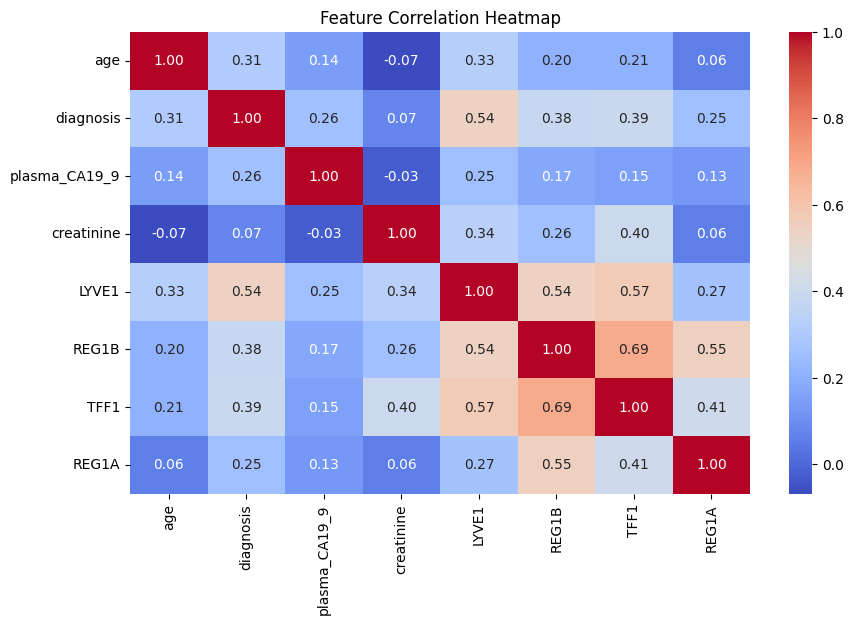

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


print(df.describe())

top_n = 15  
top_classes = df['diagnosis'].value_counts().nlargest(top_n).index
filtered_df = df[df['diagnosis'].isin(top_classes)]

plt.figure(figsize=(14, 6))
sns.countplot(data=filtered_df, x='diagnosis', order=top_classes)
plt.title(f"Top {top_n} Diagnosis Classes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


numeric_df = df.select_dtypes(include=['number'])



plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



In [5]:

columns_to_drop = ["sample_id", "patient_cohort", "sample_origin", "stage", "benign_sample_diagnosis"]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])



df = df.dropna(subset=["diagnosis", "LYVE1", "REG1B", "TFF1", "creatinine"])


df["plasma_CA19_9"] = df["plasma_CA19_9"].fillna(df["plasma_CA19_9"].median())
df["REG1A"] = df["REG1A"].fillna(df["REG1A"].median())


df["sex"] = LabelEncoder().fit_transform(df["sex"])  


df["diagnosis"] = df["diagnosis"].replace({2: 0, 3: 0})


In [7]:

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [9]:

rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]


📄 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       363
           1       0.70      0.51      0.59        37

    accuracy                           0.94       400
   macro avg       0.83      0.75      0.78       400
weighted avg       0.93      0.94      0.93       400



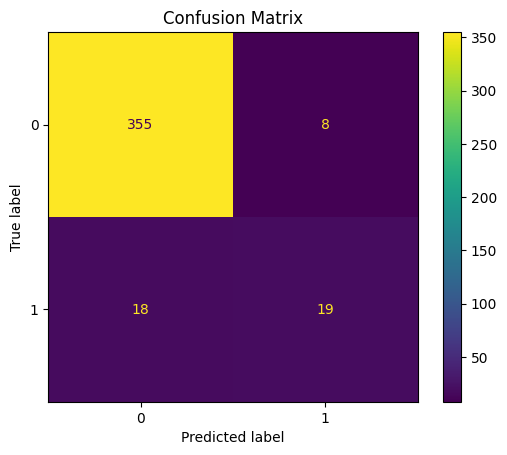

🎯 ROC AUC Score: 0.96


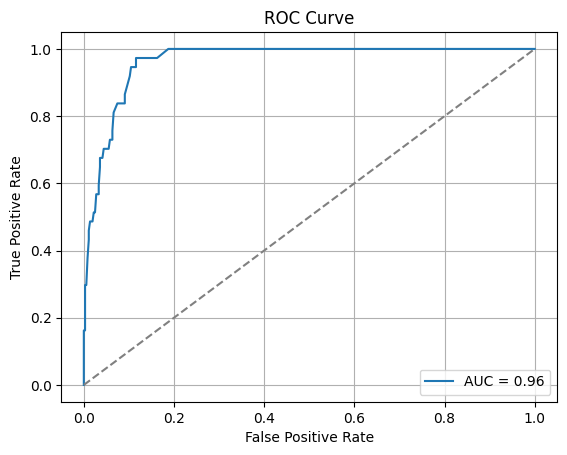

In [11]:

print(" Classification Report:\n", classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f" ROC AUC Score: {roc_auc:.2f}")

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
print(accuracy_score(y_test,y_pred))

0.935


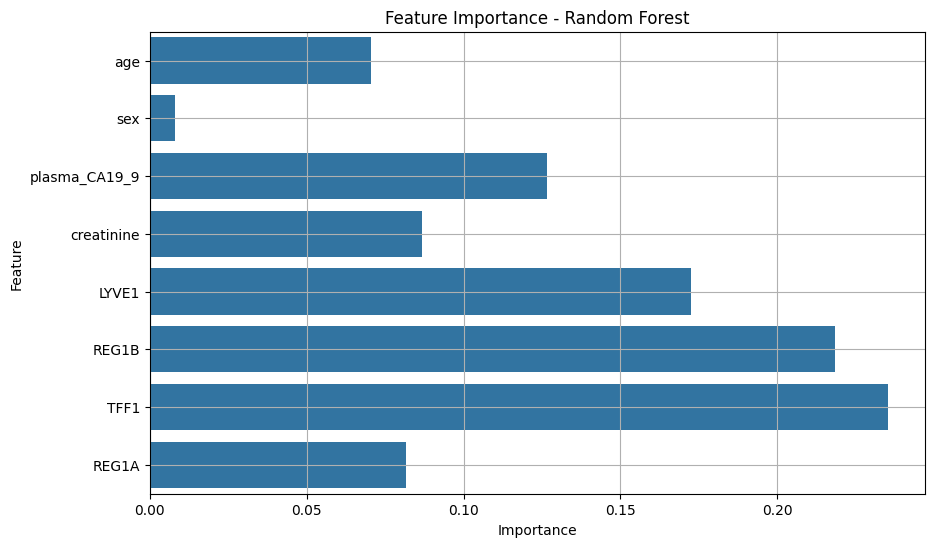

In [15]:
importances = rf.feature_importances_
feature_names = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


In [17]:
print(cm)

[[355   8]
 [ 18  19]]


In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 300],         
    'max_depth': [None, 10, 20, 30],         
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 4],          
    'max_features': ['sqrt', 'log2']        
}


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                      
    scoring='f1_macro',        
    n_jobs=-1,                 
    verbose=2
)


grid_search.fit(X_train_scaled, y_train)


best_rf = grid_search.best_estimator_


y_pred = best_rf.predict(X_test_scaled)
y_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       363
           1       0.55      0.73      0.63        37

    accuracy                           0.92       400
   macro avg       0.76      0.83      0.79       400
weighted avg       0.93      0.92      0.92       400

Confusion Matrix:
 [[341  22]
 [ 10  27]]
ROC AUC Score: 0.9616558707467798


In [21]:
print(accuracy_score(y_test,y_pred))

0.92


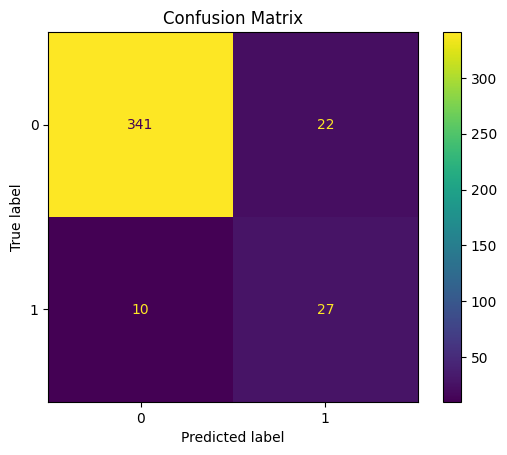

In [23]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


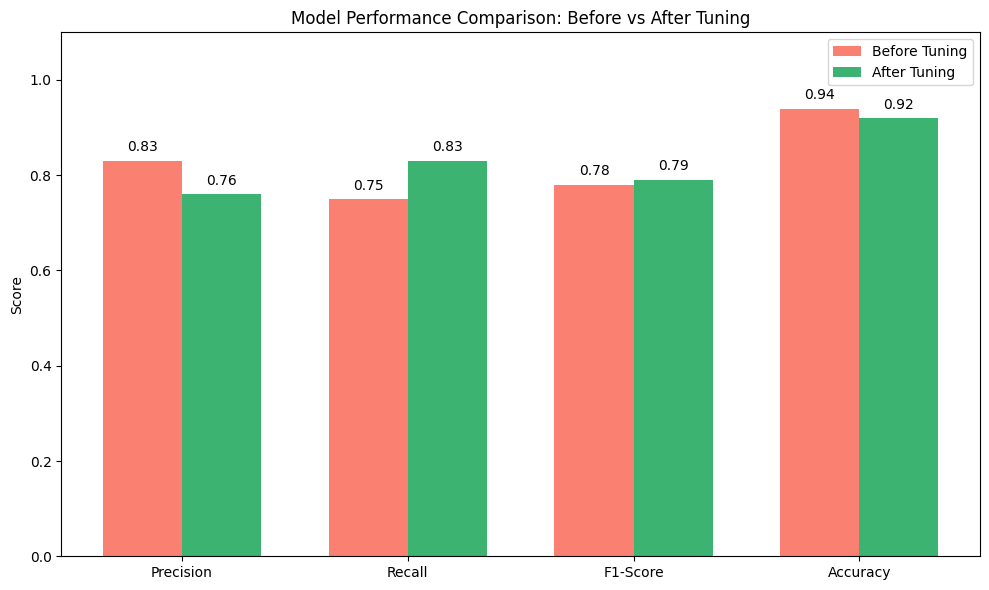

In [25]:
import matplotlib.pyplot as plt
import numpy as np

before_tuning = {
    'Precision': 0.83,
    'Recall': 0.75,
    'F1-Score': 0.78,
    'Accuracy': 0.94
}

after_tuning = {
    'Precision': 0.76,
    'Recall': 0.83,
    'F1-Score': 0.79,
    'Accuracy': 0.92
}

metrics = list(before_tuning.keys())
before_values = list(before_tuning.values())
after_values = list(after_tuning.values())

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, before_values, width, label='Before Tuning', color='salmon')
bars2 = ax.bar(x + width/2, after_values, width, label='After Tuning', color='mediumseagreen')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison: Before vs After Tuning')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()
